In [1]:
from virusPropagationModel import ModeledPopulatedWorld,Simulation
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import timeit
import matplotlib.cm as cm 
 

In [2]:
start = timeit.default_timer()
modeledWorld1 = ModeledPopulatedWorld(1000,100, world_from_file=True, geofile_name='datafiles/Buildings_Gangelt_MA_3.csv')
stop = timeit.default_timer()
print('required time: ', stop - start)  

required time:  1.4447171829999998


{'home': 496, 'work': 52, 'public_place': 11, 'school': 2, 'hospital': 1, 'cemetery': 1}


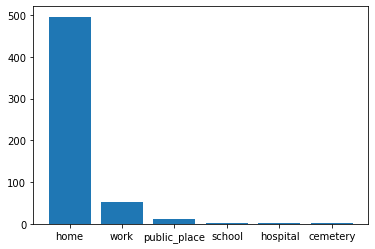

In [ ]:
loc_counts = modeledWorld1.plot_location_type_distribution()
print(loc_counts)

In [4]:
print('Number of agents:'+ str(len(modeledWorld1.people)))

Number of agents:673


In [5]:
start = timeit.default_timer()
simulation1 = Simulation(modeledWorld1,200)
stop = timeit.default_timer()
print('required time: ', stop - start)  

required time:  4.753235458000001


<Figure size 720x1080 with 0 Axes>

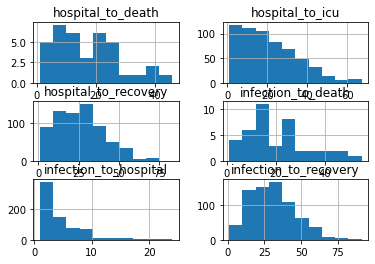

<Figure size 432x288 with 0 Axes>

In [6]:
plt.figure(figsize=(10,15))
simulation1.plot_distributions_of_durations()
plt.tight_layout()

In [7]:
loc_stat=simulation1.get_location_and_status()
print(loc_stat.head())

status  loc  time    D    I    R    S  x_coordinate  y_coordinate
0         0     1  0.0  0.0  0.0  2.0      5.988614     50.994357
1         0     2  0.0  0.0  0.0  2.0      5.988614     50.994357
2         0     3  0.0  0.0  0.0  2.0      5.988614     50.994357
3         0     4  0.0  0.0  0.0  2.0      5.988614     50.994357
4         0     5  0.0  0.0  0.0  2.0      5.988614     50.994357


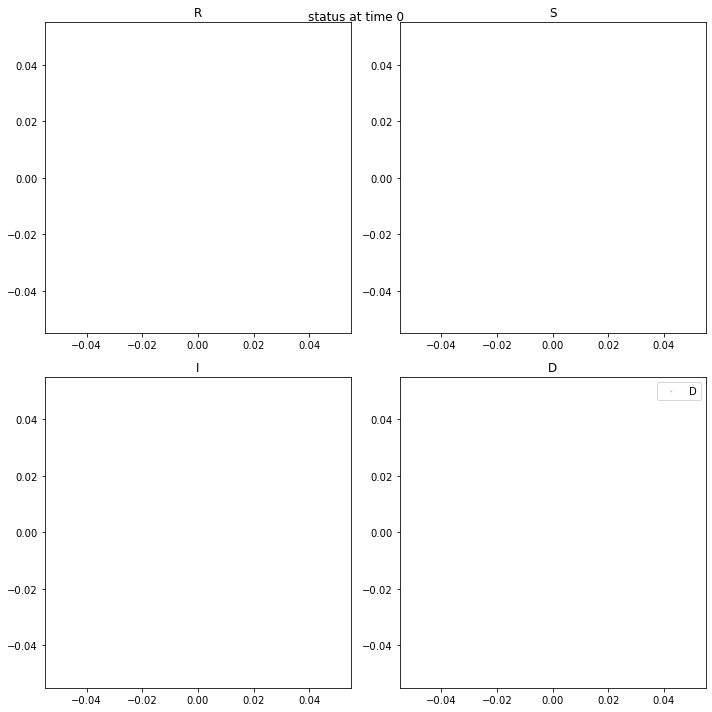

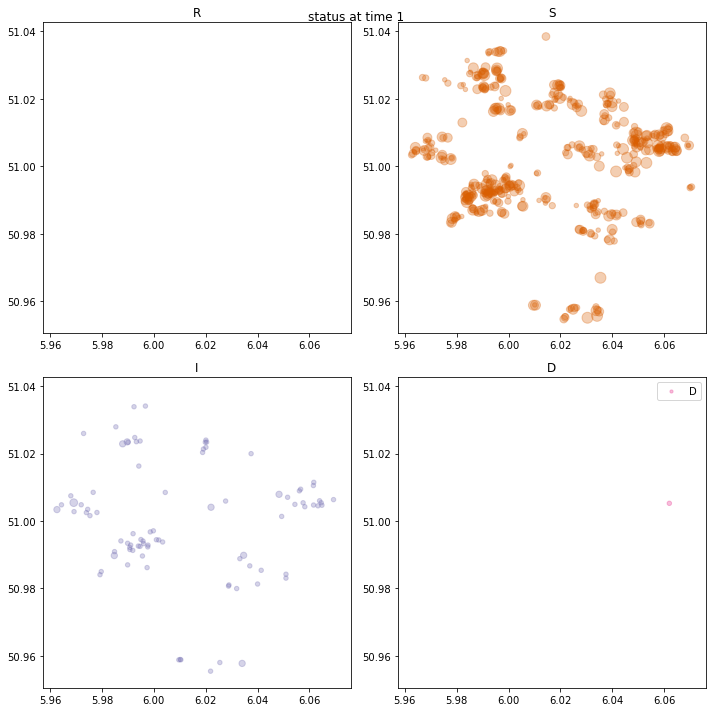

In [15]:
times = 2 
#times = max(loc_stat['time'])
for time in range(times):
    loc_stat_t = loc_stat[loc_stat['time']==time]
    cmap = cm.get_cmap('Dark2')

    plt.figure(figsize=(10,10))
    for k,stat in enumerate(['R','S','I','D']):
        plt.subplot(2,2,k+1)
        plt.title(stat)
        plt.scatter(loc_stat_t['x_coordinate'],loc_stat_t['y_coordinate'], s = 20*loc_stat_t[stat], alpha=0.3, label=stat, color=cmap(k))
    plt.suptitle('status at time '+str(time))
    plt.tight_layout()
    plt.legend()

    #plt.savefig('plots/loc_t_'+str(time)+'.png')

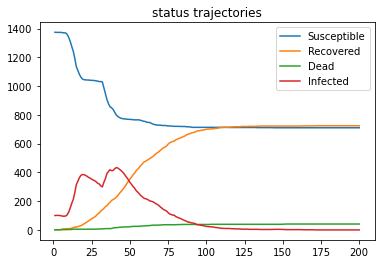

In [9]:
simulation1.plot_status_timecourse()


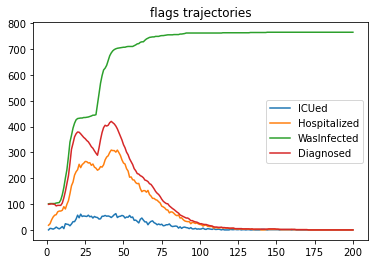

In [10]:
simulation1.plot_flags_timecourse()


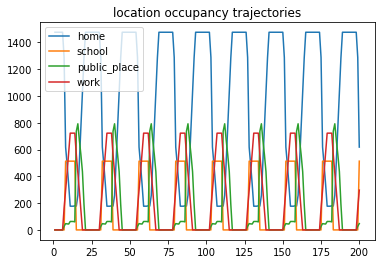

In [11]:
simulation1.plot_location_type_occupancy_timecourse()

In [12]:
# simulation1.export_time_courses_as_csvs(identifier='testing') 
# Exports the CSVs to the outputs folder.
# Files marked with the identifier 'testing' get automatically deleted by the testrunner.
# Use a different identifier name if you want your outputs to remain in the folder.
